In [24]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("GPU device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")


CUDA available: True
GPU device: NVIDIA A30


In [1]:
!ls -lh


total 52K
drwxr-xr-x 3 u.tm288329 u.tm288329  20K Nov 10 11:43 Image
drwxr-xr-x 2 u.tm288329 u.tm288329  20K Nov 10 11:41 mask
-rw-r--r-- 1 u.tm288329 u.tm288329 5.2K Nov 10 11:43 metadata.csv
-rw-r--r-- 1 u.tm288329 u.tm288329  617 Nov 10 11:42 Untitled.ipynb


In [3]:
#Imports and Setup
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm


In [9]:
import os
print("Current working directory:", os.getcwd())
print("Contents here:", os.listdir())


Current working directory: /ccstar/scratch/user/u.tm288329/Mldl_Project
Contents here: ['mask', 'Image', 'metadata.csv', 'Untitled.ipynb', '.ipynb_checkpoints']


In [10]:
base_dir = os.getcwd()
img_dir = os.path.join(base_dir, "Image")
mask_dir = os.path.join(base_dir, "mask")


In [11]:
print("Images:", os.path.exists(img_dir))
print("Masks:", os.path.exists(mask_dir))
print("Images count:", len(os.listdir(img_dir)))
print("Masks count:", len(os.listdir(mask_dir)))


Images: True
Masks: True
Images count: 291
Masks count: 290


In [15]:
import os

img_set = set(os.listdir(img_dir))
mask_set = set(os.listdir(mask_dir))

print("Images:", len(img_set), "| Masks:", len(mask_set))
print("Missing mask files:", img_set - mask_set)
print("Extra mask files:", mask_set - img_set)


Images: 291 | Masks: 290
Missing mask files: {'1019.jpg', '2053.jpg', '1034.jpg', '2.jpg', '2023.jpg', '3090.jpg', '1069.jpg', '2003.jpg', '3060.jpg', '2045.jpg', '1060.jpg', '3017.jpg', '27.jpg', '1082.jpg', '3050.jpg', '2001.jpg', '1008.jpg', '30.jpg', '3085.jpg', '3059.jpg', '46.jpg', '2051.jpg', '1005.jpg', '2033.jpg', '3010.jpg', '3064.jpg', '1049.jpg', '2043.jpg', '2034.jpg', '2049.jpg', '2008.jpg', '3084.jpg', '3019.jpg', '38.jpg', '1011.jpg', '3023.jpg', '1072.jpg', '1017.jpg', '2020.jpg', '13.jpg', '2005.jpg', '3066.jpg', '3082.jpg', '3047.jpg', '3008.jpg', '14.jpg', '2015.jpg', '15.jpg', '1012.jpg', '2044.jpg', '1036.jpg', '8.jpg', '1021.jpg', '3048.jpg', '3097.jpg', '3061.jpg', '3022.jpg', '3057.jpg', '1065.jpg', '2004.jpg', '2009.jpg', '1053.jpg', '2048.jpg', '3080.jpg', '35.jpg', '3027.jpg', '2041.jpg', '3071.jpg', '1057.jpg', '3006.jpg', '3013.jpg', '3044.jpg', '3065.jpg', '33.jpg', '49.jpg', '3088.jpg', '3030.jpg', '3053.jpg', '1016.jpg', '1043.jpg', '1077.jpg', '1062.jp

In [16]:
class FloodDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform

        img_files = sorted(os.listdir(img_dir))
        mask_files = sorted(os.listdir(mask_dir))

        # Keep only common file names (ignore extensions)
        img_names = {os.path.splitext(f)[0] for f in img_files}
        mask_names = {os.path.splitext(f)[0] for f in mask_files}
        common = sorted(img_names & mask_names)

        self.img_files = [f"{name}.jpg" for name in common if f"{name}.jpg" in img_files or f"{name}.png" in img_files]
        self.mask_files = [f"{name}.jpg" if f"{name}.jpg" in mask_files else f"{name}.png" for name in common]

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])
        image = Image.open(img_path).convert("RGB").resize((224, 224))
        mask = Image.open(mask_path).convert("L").resize((224, 224))
        mask = np.array(mask, dtype=np.float32) / 255.0
        mask = np.expand_dims(mask, axis=0)

        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(mask, dtype=torch.float32)


In [17]:
dataset = FloodDataset(img_dir, mask_dir, transform)
print("Total paired samples:", len(dataset))

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=4)


Total paired samples: 290


In [18]:
#U-Net Model
import torch.nn as nn
import torch.nn.functional as F

# Simple U-Net architecture
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
            )

        self.enc1 = conv_block(3, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = conv_block(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = conv_block(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = conv_block(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = conv_block(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.out = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        b = self.bottleneck(self.pool(e4))

        d4 = self.up4(b)
        d4 = torch.cat((d4, e4), dim=1)
        d4 = self.dec4(d4)

        d3 = self.up3(d4)
        d3 = torch.cat((d3, e3), dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat((d1, e1), dim=1)
        d1 = self.dec1(d1)

        return torch.sigmoid(self.out(d1))


In [19]:
#Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    for imgs, masks in tqdm(train_dl, desc=f"Epoch {epoch+1}/{num_epochs}"):
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_dl)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for imgs, masks in val_dl:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
    val_loss /= len(val_dl)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


Epoch 1/10: 100%|██████████| 58/58 [00:10<00:00,  5.45it/s]


Epoch [1/10] | Train Loss: 0.4564 | Val Loss: 0.4539


Epoch 2/10: 100%|██████████| 58/58 [00:10<00:00,  5.58it/s]


Epoch [2/10] | Train Loss: 0.3802 | Val Loss: 0.4744


Epoch 3/10: 100%|██████████| 58/58 [00:10<00:00,  5.60it/s]


Epoch [3/10] | Train Loss: 0.3655 | Val Loss: 0.4121


Epoch 4/10: 100%|██████████| 58/58 [00:10<00:00,  5.57it/s]


Epoch [4/10] | Train Loss: 0.3581 | Val Loss: 0.4479


Epoch 5/10: 100%|██████████| 58/58 [00:10<00:00,  5.57it/s]


Epoch [5/10] | Train Loss: 0.3509 | Val Loss: 0.4033


Epoch 6/10: 100%|██████████| 58/58 [00:10<00:00,  5.65it/s]


Epoch [6/10] | Train Loss: 0.3402 | Val Loss: 0.4000


Epoch 7/10: 100%|██████████| 58/58 [00:10<00:00,  5.64it/s]


Epoch [7/10] | Train Loss: 0.3121 | Val Loss: 0.4233


Epoch 8/10: 100%|██████████| 58/58 [00:10<00:00,  5.60it/s]


Epoch [8/10] | Train Loss: 0.3216 | Val Loss: 0.3852


Epoch 9/10: 100%|██████████| 58/58 [00:10<00:00,  5.56it/s]


Epoch [9/10] | Train Loss: 0.3197 | Val Loss: 0.3851


Epoch 10/10: 100%|██████████| 58/58 [00:10<00:00,  5.62it/s]


Epoch [10/10] | Train Loss: 0.3092 | Val Loss: 0.3976


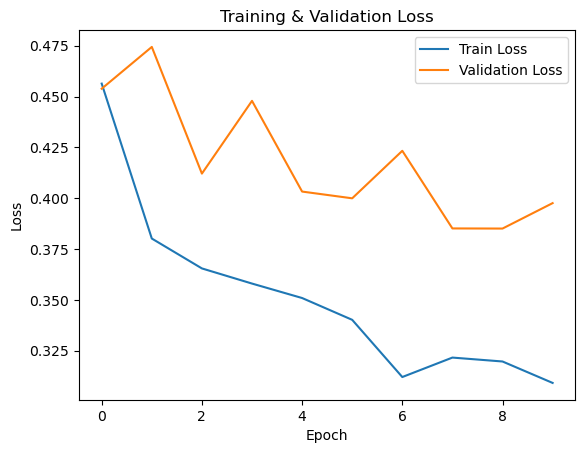

In [20]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()


In [22]:
def iou_score(pred, target, threshold=0.5):
    pred = (pred > threshold).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + 1e-6) / (union + 1e-6)

def dice_score(pred, target, threshold=0.5):
    pred = (pred > threshold).float()
    intersection = (pred * target).sum()
    return (2 * intersection + 1e-6) / (pred.sum() + target.sum() + 1e-6)

model.eval()
iou_total, dice_total = 0, 0

with torch.no_grad():
    for imgs, masks in val_dl:
        imgs, masks = imgs.to(device), masks.to(device)
        outputs = model(imgs)
        iou_total += iou_score(outputs, masks)
        dice_total += dice_score(outputs, masks)

mean_iou = (iou_total / len(val_dl)).item()
mean_dice = (dice_total / len(val_dl)).item()
print(f" Mean IoU: {mean_iou:.4f} | Mean Dice: {mean_dice:.4f}")


 Mean IoU: 0.6537 | Mean Dice: 0.7769


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


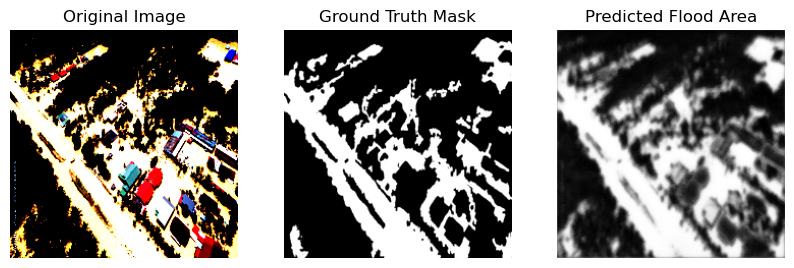

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


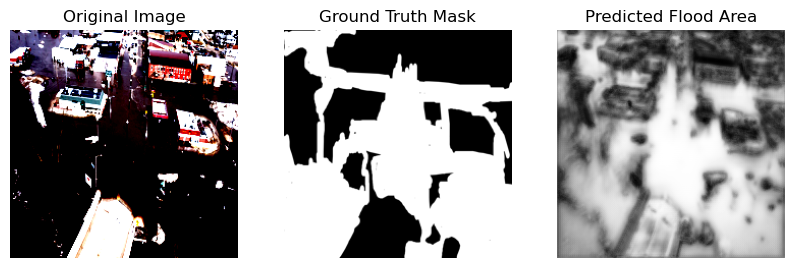

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


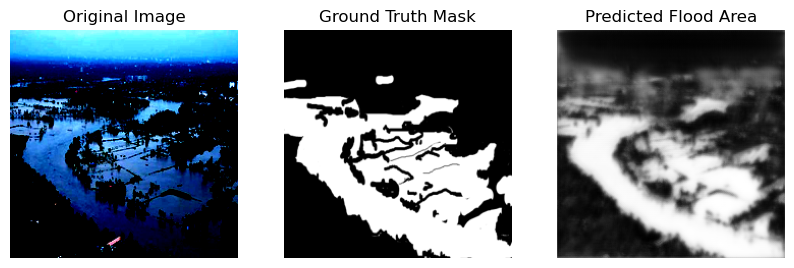

In [23]:
import matplotlib.pyplot as plt

model.eval()
imgs, masks = next(iter(val_dl))
imgs, masks = imgs.to(device), masks.to(device)

with torch.no_grad():
    preds = model(imgs)

for i in range(3):  # Show 3 random samples
    plt.figure(figsize=(10, 3))
    
    plt.subplot(1, 3, 1)
    plt.imshow(np.transpose(imgs[i].cpu(), (1, 2, 0)))
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(masks[i].cpu().squeeze(), cmap="gray")
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(preds[i].cpu().squeeze(), cmap="gray")
    plt.title("Predicted Flood Area")
    plt.axis("off")

    plt.show()
